# Inferring parameters for the Beeler-Reuter Model

In this notebook, we use PINTS to create noisy data for a Beeler-Reuter system and then perform inference on the model
to try and retrieve the parameters. This should be compared with results from other notebooks, such as the FitzHugh-Nagumo
notebook.

## Creating the ForwardModel

### Variable descriptions

Firstly, we set up the system of ODEs for the Beeler-Reuter system. Below is a description of the 8 time-dependent variables
present in the model (which form a system of 8 ODEs), and we follow the notation of Keener and Sneyd (1998) Section 4.3 [$^{[1]}$](#Sources).

|variable|description|ion|
|---|-------|---|
|$V$|membrane potential|all|
|$m$|fast sodium activation gating variable|$Na^{+}$|
|$h$|fast sodium inactivation gating variable|$Na^{+}$|
|$j$|fast sodium reactivation gating variable|$Na^{+}$|
|$d$|slow inward calcium activation gating variable|$Ca^{2+}$|
|$f$|slow inward calcium inactivation gating variable|$Ca^{2+}$|
|$c$|$10^{7}[Ca]_{i}$ where $[Ca]_{i}$ is the internal calcium concentration|$Ca^{2+}$|
|$x$|outward potassium gating variable|$K^{+}$|

### Membrane potential ODE

For the ODEs, we follow some of the notation from the original Beeler and Reuter paper from 1977 [$^{[2]}$](#Sources).
The governing ODE for the membrane potential is:

\begin{equation}
    C_{m}\frac{dV}{dt} = - (I_{Na} + I_{K} + I_{x} + I_{Ca}) + I_{stim},
\end{equation}
where
\begin{equation}
    I_{Na} = (g_{Na}m^{3}hj + g_{NaC})(V - V_{Na}),
\end{equation}
\begin{equation}
    I_{K} = g_{K_1}\frac{\exp{(0.04(V - V_{K_1}))} - 1}{\exp{(0.08(V - V_{K_2}))} + \exp{(0.04(V - V_{K_2}))}} + 
            g_{K_2}\frac{V - V_{K_3}}{1 - \exp{(- 0.04(V - V_{K_3}))}},
\end{equation}
\begin{equation}
    I_{x} = g_{x}x\frac{\exp{(0.04(V - V_{x_1}))} - 1}{\exp{(0.04(V - V_{x_2}))}},
\end{equation}
\begin{equation}
    I_{Ca} = g_{Ca}fd(V - V_{Ca} + 13.0287\ln{(10^{-7}c))}.
\end{equation}

During inference, the model will have the capability to infer any of the conductances, $g_{i}$ for any subscript $i$, and any of the
Nernst (or other) potential constants, $V_{i}$. Therefore we have up to 13 parameters (6 conductances and 7 potentials) to infer. Note that 
we also fix $C_{m}$ = 1.

For the stimulating current, $I_{stim}$, we will allow flexibility for specifying the following parameters:

|parameter|description|
|---|--------|
|`stim_start`|The time at which the current is turned on.|
|`stim_period`|The length of a stimulation cycle.|
|`stim_duration`|The period for which (at the start of the stimulation cycle) the current is turned on.|
|`stim_amplitude`|The amplitude of the current.|

These will be captured in a 4-membered list, and passed to the `BeelerReuterModel` below. None of these parameters will be inferred.

### Gating variable and $Ca^{2+}$ ODEs

Below are the remaining 7 ODEs:

\begin{equation}
    \frac{dy}{dt} = \alpha_{y}(1 - y) - \beta_{y}y,
\end{equation}
\begin{equation}
    \frac{dc}{dt} = 0.07(1 - c) - I_{Ca},
\end{equation}

where $y = m, h, j, d, f, x$ and $\alpha_{y}, \beta_{y}$ are some known functions of the membrane potential, $V$ (so we will
not be inferring any parameters contained within these functions).

### Initial conditions

Finally, we will assume the following initial conditions are known (using values from CellML [$^{[3]}$](#Sources)):

\begin{equation}
    V(0) = -84.624, \qquad m(0) = 0.011, \qquad h(0) = 0.988, \qquad j(0) = 0.975, \qquad d(0) = 0.003, \qquad f(0) = 0.994, 
    \qquad x(0) = 0.0001, \qquad c(0) = 2.
\end{equation}

The goal is to try and initially infer all 13 parameters, and then see which parameters we can restrict to improve the overall inference.

In [1]:
initial_conditions = [-84.624, 0.011, 0.988, 0.975, 0.003, 0.994, 0.0001, 2]

In [2]:
from numpy import exp, log

import pints
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt

### PINTS implementation of the model

In addition to implementing the system, we give the option in the class to specify fixed parameters, if we wish to 
reduce the dimensions of the parameter space. Additionally, as we realistically would only be able to measure the membrane potential,
$V$, and the calcium concentration, $c$, we will use these as the only outputs of the system.

In [3]:
class BeelerReuterModel(pints.ForwardModel):

    def __init__(self, initial_conditions, stimulating_current, fixed_params=None, outputs=["V", "c"],
                 rtol=10**(-3), atol=10**(-6)):
        """Initialises the forward model with certain fixed parameters passed to the method
        as key-value pairs.
        """
        super(BeelerReuterModel, self).__init__()
        assert len(initial_conditions) == 8
        self._initial_conditions = initial_conditions

        assert len(stimulating_current) == 4
        self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude = tuple(stimulating_current)
        self._param_names = ["g_Na", "g_NaC", "g_K1", "g_K2", "g_x", "g_Ca",
                             "V_Na", "V_K1", "V_K2", "V_K3", "V_x1", "V_x2", "V_Ca"]
        self._variable_names = ["V", "m", "h", "j", "d", "f", "x", "c"]
        self._fixed_params = {}
        if fixed_params is not None:
            for k in fixed_params.keys():
                if k in self._param_names:
                    self._fixed_params[k] = fixed_params[k]

        assert 1 <= len(outputs) <= 8
        assert set(outputs).issubset(set(self._variable_names))
        self._outputs = outputs
        self._rtol = rtol
        self._atol = atol

    def get_param_names(self):
        """Returns the parameter names.
        """
        return self._param_names

    def get_unfixed_param_names(self):
        """Returns the unfixed parameters
        """
        output_list = self._param_names.copy()
        for fixed_param in self._fixed_params.keys():
            output_list.remove(fixed_param)
        return output_list

    def n_outputs(self):
        """Returns number of model outputs, default to just V and c
        """
        return len(self._outputs)

    def n_parameters(self):
        """Returns number of parameters to be inferred, i.e. all non-fixed parameters.
        """
        return len(self._param_names) - len(self._fixed_params)

    def n_fixed_parameters(self):
        """Returns number of parameters we fix.
        """
        return len(self._fixed_params)

    def simulate(self, parameters, times):
        """This inherits from pints.ForwardModel, performs one forward simulation of the model.
        The list `parameters` contains only the parameters we are inferring.
        """
        g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca = self._get_all_params(parameters)
        t_span = [times[0], times[len(times) - 1]]
        y0 = self._initial_conditions
        sol = si.solve_ivp(fun=self._rhs, t_span=t_span, y0=y0, 
                           t_eval=times, args=(g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
                                               V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
                                               self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude),
                           rtol=self._rtol, atol=self._atol)

        # Now we find which outputs we wish to use
        output_indices = [self._variable_names.index(variable) for variable in self._outputs]
        return np.array([sol.y[index, :] for index in output_indices]).transpose()

    def _get_all_params(self, parameters):
        """We need a list of 13 parameters, so we check to see which parameters are fixed, and which are not.
        We increment j each time a non-fixed parameter is reached.
        """
        all_parameters = []
        j = 0
        for param in self._param_names:
            if param in self._fixed_params.keys():
                all_parameters.append(self._fixed_params[param])
            else:
                all_parameters.append(parameters[j])
                j += 1
        return tuple(all_parameters)

    @staticmethod
    def _rhs(t, y, g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
             V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
             stim_start, stim_period, stim_duration, stim_amplitude):
        """The right hand side function of the Beeler-Reuter system.
        """
        # Variables
        V, m, h, j, d, f, x, c = tuple(list(y))

        # Currents
        I_Na = (g_Na * (m**3) * h * j + g_NaC) * (V - V_Na)
        I_K = g_K1 * (exp(0.04 * (V - V_K1)) - 1) / (exp(0.08 * (V - V_K2)) + exp(0.04 * (V - V_K2))) + g_K2 * (V - V_K3) / (1 - exp(-0.04 * (V - V_K3)))
        I_x = g_x * x * (exp(0.04 * (V - V_x1)) - 1) / exp(0.04 * (V - V_x2))
        I_Ca = g_Ca * d * f * (V - V_Ca + 13.0287 * (log(c) - 7 * log(10)))

        # Stimulation parameters
        if (t - stim_start) % stim_period <= stim_duration:
            I_stim = stim_amplitude
        else:
            I_stim = 0

        # Membrane potential ODE
        V_dot = - (I_Na + I_K + I_x + I_Ca) + I_stim

        # Gating variable ODEs
        m_dot = (V + 47) / (1 - exp(-0.1 * (V + 47))) * (1 - m) - 40 * exp(-0.056 * (V + 72)) * m
        h_dot = 0.126 * exp(-0.25 * (V + 77)) * (1 - h) - 1.7 / (1 + exp(-0.082 * (V + 22.5))) * h
        j_dot = 0.055 * exp(-0.25 * (V + 78)) / (1 + exp(-0.2 * (V + 78))) * (1 - j) - 0.3 / (1 + exp(-0.1 * (V + 32))) * j
        d_dot = 0.095 * exp(-0.01 * (V + -5)) / (exp(-0.072 * (V + -5)) + 1) * (1 - d) - 0.07 * exp(-0.017 * (V + 44)) / (exp(0.05 * (V + 44)) + 1) * d
        f_dot = 0.012 * exp(-0.008 * (V + 28)) / (exp(0.15 * (V + 28)) + 1) * (1 - f) - 0.0065 * exp(-0.02 * (V + 30)) / (exp(-0.2 * (V + 30)) + 1) * f
        x_dot = 0.0005 * exp(0.083 * (V + 50)) / (exp(0.057 * (V + 50)) + 1) * (1 - x) - 0.0013 * exp(-0.06 * (V + 20)) / (exp(-0.04 * (V + 20)) + 1) * x

        # Calcium concentration ODE
        c_dot = 0.07 * (1 - c) - I_Ca
        return np.array([V_dot, m_dot, h_dot, j_dot, d_dot, f_dot, x_dot, c_dot])


## Generating data for the model

### Simulating the system

Next, we will generate some data for the model using known parameter values. We use the ones chosen by Keener and Sneyd (pg 150) [$^{[1]}$](#Sources), tabulated below:

|parameter|value|
|-----|-----|
|$g_{Na}$|4|
|$g_{NaC}$|0.003|
|$g_{K_1}$|1.4|
|$g_{K_2}$|0.07|
|$g_{x}$|0.8|
|$g_{Ca}$|0.09|
|$V_{Na}$|50|
|$V_{K_1}$|-85|
|$V_{K_2}$|-53|
|$V_{K_3}$|-23|
|$V_{x_1}$|-77|
|$V_{x_2}$|-35|
|$V_{Ca}$|-82.3|

The below stimulation parameters are related to ones chosen in CellML [$^{[3]}$](#Sources).

Conductances: $g_{Na},$ $g_{NaC},$ $g_{K_1},$ $g_{K_2},$ $g_{x},$ $g_{Ca}$

Nernst potentials and other potential constants: $V_{Na},$ $V_{K_1},$ $V_{K_2},$ $V_{K_3},$ $V_{x_1},$ $V_{x_2},$ $V_{Ca}$

In [4]:
# Here we fix the potentials
fixed_params = {"V_Na": 50, "V_K1": -85, "V_K2": -53, "V_K3": -23, "V_x1": -77, "V_x2": -35, "V_Ca": -82.3}
# fixed_params = None
# Stimulation parameters [stim_start, stim_period, stim_duration, stim_amplitude]
stim_params = [1, 1000, 2, 25]

In [5]:
model = BeelerReuterModel(initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V"], rtol=10**(-8), atol=10**(-8))
param_names = model.get_unfixed_param_names()
print(param_names)
parameters = np.array([4, 0.003, 1.4, 0.07, 0.8, 0.09])
times = np.arange(0, 400, 4)

['g_Na', 'g_NaC', 'g_K1', 'g_K2', 'g_x', 'g_Ca']


In [7]:
data = model.simulate(parameters, times)

In [7]:
import pandas as pd

In [8]:
output_param_df = pd.DataFrame({"true": parameters})

### Adding noise to the system

We now utilise PINTS noise generators to create some noisy data for the system. Specifically, `pints.noise.independent`
creates independent Gaussian noise iid $\mathcal{N}(0, \sigma)$.

In [11]:
sigma = 1
noisy_data = data + pints.noise.independent(sigma, data.shape)

### Plotting time series and phase plane

In [9]:
import matplotlib.pyplot as plt

In [12]:
noisy_df = pd.DataFrame(noisy_data, columns=["V"])
noisy_df.to_csv("simulation_outputs/noisy_data_tol.csv")

In [9]:
noisy_data = pd.read_csv("simulation_outputs/noisy_data_tol.csv", index_col=0).to_numpy()
# V, c = data[:, 0], data[:, 1]

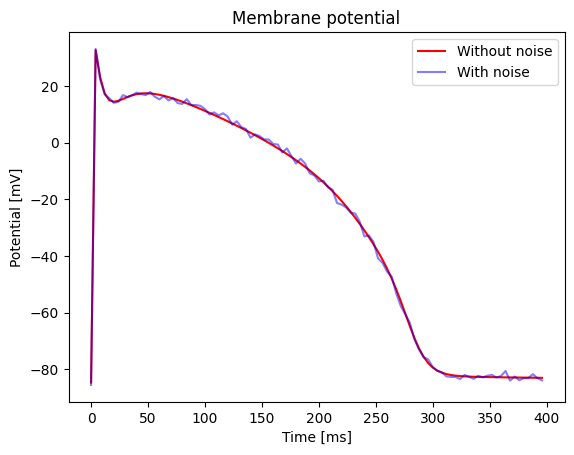

In [14]:
V = data[:, 0]
# noisy_V, noisy_c = noisy_data[:, 0], noisy_data[:, 1]
noisy_V = noisy_data[:, 0]
plt.plot(times, V, "-r", label="Without noise")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title("Membrane potential")
plt.savefig("simulation_outputs/time_series_tol.png")

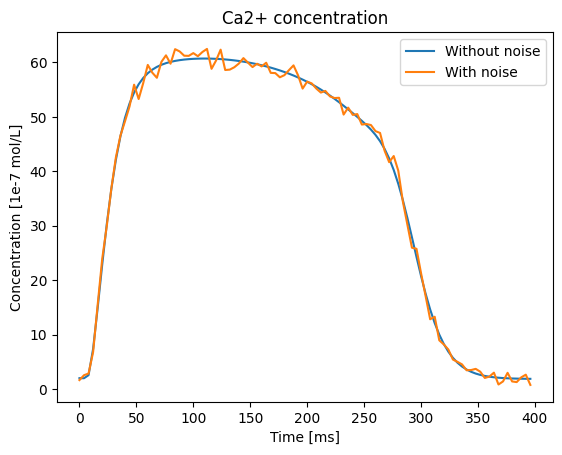

In [20]:
plt.plot(times, c, label="Without noise")
plt.plot(times, noisy_c, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Ca2+ concentration")
plt.savefig("simulation_outputs/time_series_c.png")

## Using PINTS to perform inference

We will now perform Bayesian inference on the model to try and recover the values of the input parameters. Here, we use the CMAES-ACMC
combination by optimising the problem first to find starting parameters with CMAES and then using ACMC to perform Bayesian inference
on the parameters.

### Optimisation using `pints.CMAES`

We first use the optimiser to reach some realistic parameter values for the noisy data.

In [10]:
problem = pints.MultiOutputProblem(model, times, noisy_data)
score = pints.SumOfSquaresError(problem)

Next, choose some boundaries for the parameters. We know the signs of the Nernst potentials, as K$^{+}$ flows out of the cell
and Na$^{+}$, Ca$^{2+}$ flow into the cell. For the conductances, we assume that we can know their order of magnitude.

In [11]:
boundaries = pints.RectangularBoundaries([0, 0, 0, 0, 0, 0],
                                        [10, 0.1, 10, 1, 1, 1])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_11892\629715680.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [12]:
num_opts = 10

And here we perform the optimisation. We choose to run this `num_opts` times to try and find the optimal solution of the different
optimised parameters. Each optimisation is deemed complete if the objective function has not changed by more than $10^{-8}$ over a
period of $200$ iterations. We save the parameters from each optimisation to a .csv file.

In [32]:
for j in range(7, num_opts):
    xs = log_prior.sample(1)
    sigma = [0.1, 0.001, 0.1, 0.01, 0.01, 0.01]
    # transform = pints.RectangularBoundariesTransformation(boundaries)
    opt = pints.OptimisationController(score, xs, boundaries=boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.00000001)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
    opt_param_df.to_csv(f"optimisation_outputs/parameters_tol/conductances_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Current   Time m:s
0     9      436120.8  436120.8   0:21.3
1     18     406899.7  406899.7   0:43.4
2     27     400851.7  400851.7   1:03.1
3     36     394707.6  394707.6   1:21.9
20    189    12869.87  114515.8   6:05.6
40    369    5653.193  7768.319  11:00.9
60    549    2884.276  3290.177  16:03.5
80    729    2679.228  2679.228  21:20.2
100   909    2544.869  2544.869  26:39.0
120   1089   2130.514  2131.324  31:58.4
140   1269   1464.662  1464.662  37:19.1
160   1449   464.2559  464.2559  42:45.0
180   1629   239.9443  239.9443  48:09.8
200   1809   108.8547  115.0666  53:37.4
220   1989   100.8461  100.8461  59:11.6
240   2169   100.3752  100.3752  64:49.5
260   2349   100.1922  100.1922  70:21.9
280   2529   99.97554  99.97554  75:54.2
300   2709   99.54595  99.54595  81:28.4
320   2889   99.03368  99.11038  87:04.2
340 

If the optimisation has not converged, but has a sufficiently low score, we will take the parameters at this stage.

In [23]:
opt_params = opt.optimiser().x_best()
# opt_params = (boundaries.lower() + boundaries.upper()*exp(transformed_opt_params))/(1 + exp(transformed_opt_params))

Save these parameters to a .csv file and then read from the file afterwards.

In [24]:
import pandas as pd

In [25]:
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
opt_param_df.to_csv(f"optimisation_outputs/parameters_tol/conductances_{6}.csv")

### Plotting with optimised parameters 

In [13]:
opt_params = []
num_opts = 10
for j in range(num_opts):
    opt_param_df = pd.read_csv(f"optimisation_outputs/parameters_tol/conductances_{j}.csv", index_col=0)
    opt_params.append(opt_param_df.to_numpy()[0])

In [14]:
errors = []
for j in range(num_opts):
    print("---------------------------------------------------------------------------")
    error = score(opt_params[j])
    print(f"Optimisation {j}, sum of squared errors = {round(error, 5)}")
    print("---------------------------------------------------------------------------")
    errors.append(error)
    output_list = []
    for i in range(model.n_parameters()):
        opt_param = round(opt_params[j][i], 5)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[i]}, True: {parameters[i]}, Optimised: {opt_param}")
    output_param_df[f"Optimisation {j}"] = output_list

---------------------------------------------------------------------------
Optimisation 0, sum of squared errors = 92.36647
---------------------------------------------------------------------------
Parameter: g_Na, True: 4.0, Optimised: 3.85805
Parameter: g_NaC, True: 0.003, Optimised: 0.00298
Parameter: g_K1, True: 1.4, Optimised: 1.37522
Parameter: g_K2, True: 0.07, Optimised: 0.06582
Parameter: g_x, True: 0.8, Optimised: 0.75125
Parameter: g_Ca, True: 0.09, Optimised: 0.08379
---------------------------------------------------------------------------
Optimisation 1, sum of squared errors = 92.36647
---------------------------------------------------------------------------
Parameter: g_Na, True: 4.0, Optimised: 3.8583
Parameter: g_NaC, True: 0.003, Optimised: 0.00298
Parameter: g_K1, True: 1.4, Optimised: 1.37534
Parameter: g_K2, True: 0.07, Optimised: 0.06582
Parameter: g_x, True: 0.8, Optimised: 0.75115
Parameter: g_Ca, True: 0.09, Optimised: 0.08378
---------------------------

In [15]:
chosen_opt = 3

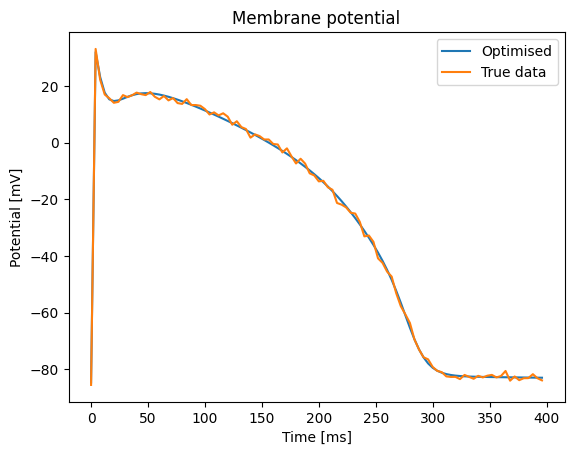

In [35]:
opt_soln = model.simulate(opt_params[chosen_opt], times)
# opt_V, opt_c = opt_soln[:, 0], opt_soln[:, 1]
opt_V = opt_soln[:, 0]
plt.plot(times, opt_V, label="Optimised")
plt.plot(times, noisy_V, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title("Membrane potential")
plt.savefig(f"optimisation_outputs/time_series_tol_{chosen_opt}.png")

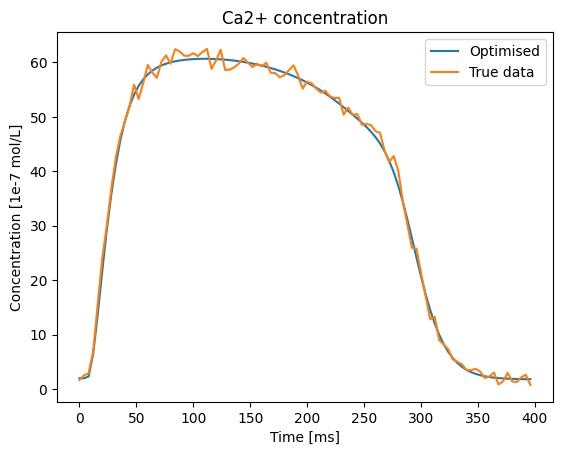

In [29]:
plt.plot(times, opt_c, label="Optimised")
plt.plot(times, noisy_c, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Ca2+ concentration")
plt.savefig(f"optimisation_outputs/time_series_c_{chosen_opt}.png")

### Inference using `pints.HaarioBardenetACMC`

In [16]:
log_likelihood = pints.GaussianLogLikelihood(problem)
composed_log_prior = pints.ComposedLogPrior(log_prior,
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            # pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
                                           )
log_posterior = pints.LogPosterior(log_likelihood, composed_log_prior)

### Initialising chains

Here, we initialise the chain with the optimised parameters. We only need one chain for our purpose as we use
parameters close to the true value.

In [37]:
# xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [1] + [1]), (1, 1))
xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [1]), (1, 1))
num_chains = 1
# transform = pints.RectangularBoundariesTransformation([0, 0, 0, 0, 0, 0, 0, 0],
#                                         [10, 1, 10, 1, 1, 1, 10, 10])
transform = pints.RectangularBoundariesTransformation([0, 0, 0, 0, 0, 0, 0],
                                        [10, 1, 10, 1, 1, 1, 10])

### Performing inference

In [38]:
n_params = log_prior.n_parameters()
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.HaarioBardenetACMC, transformation=transform)
max_iterations = 20000
mcmc.set_max_iterations(max_iterations)
# mcmc.set_parallel(True)
# print(mcmc.parallel())

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:01.9
1     2      0          0:03.8
2     3      0          0:05.6
3     4      0          0:07.6
20    21     0          0:40.7
40    41     0          1:20.9
60    61     0          1:59.0
80    81     0          2:37.7
100   101    0          3:16.1
120   121    0          4:00.3
140   141    0          4:39.5
160   161    0          5:21.0
180   181    0          5:59.2
Initial phase completed.
200   201    0          6:37.7
220   221    0.0181     7:15.9
240   241    0.0539     7:54.0
260   261    0.0958     8:32.0
280   281    0.125      9:10.2
300   301    0.146      9:49.9
320   321    0.159     10:29.6
340   341    0.164     11:07.7
360   361    0.175     11:46.1
380   381    0.178     12:24.4
400   401    0.182     13:02.3
420   421    0.192399  13:40.6
440   441    0.193     14:19.3
460   461    0.193     14:58.7
480   481  

If we haven't quite reached the limit, save the chains here.

In [34]:
# mcmc.set_max_iterations(5020)
# chains = mcmc.run()
# chains = mcmc.chains()

RuntimeError: Controller is valid for single use only

### Saving chains

In [39]:
import pandas as pd

In [20]:
# all_param_names = param_names + ["sigma_V", "sigma_c"]
all_param_names = param_names + ["sigma_V"]

In [41]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=all_param_names)
    df.to_csv(f"chain_data/conductances_tol/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [17]:
num_chains = 1
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv(f"chain_data/conductances_tol/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [18]:
import setuptools

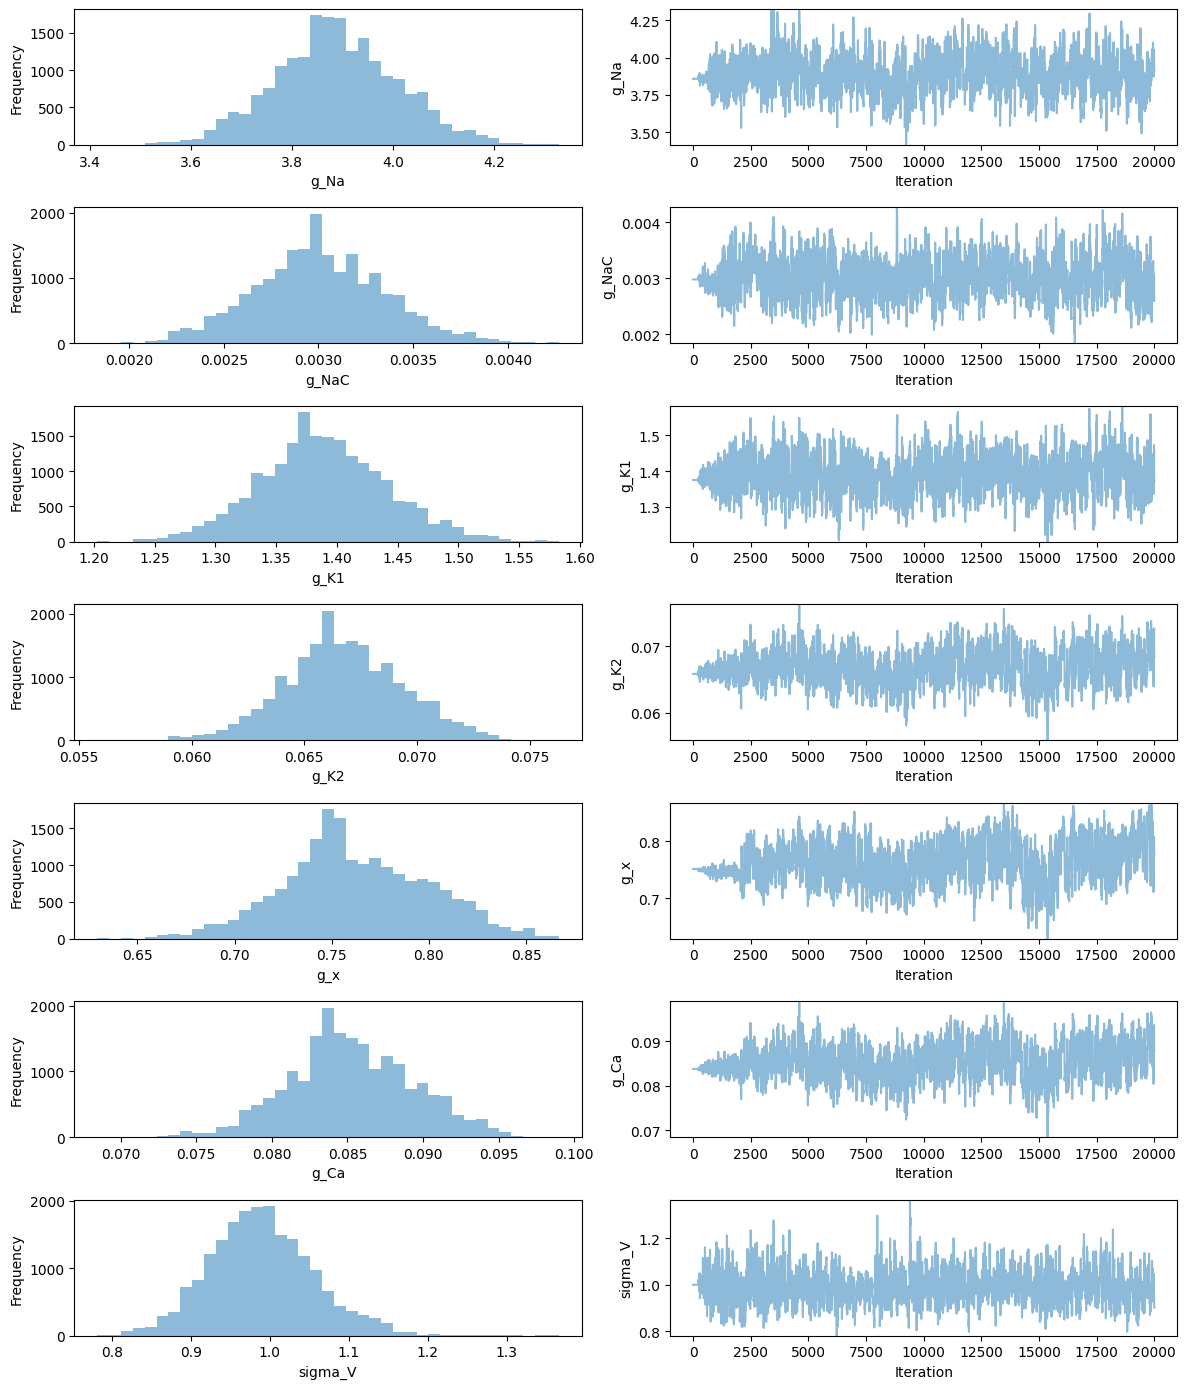

In [21]:
import pints.plot
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [22]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(all_param_names)):
    print(f"R_hat value for {all_param_names[i]}: {round(r_hat_values[i], 5)}")
output_param_df["R hat"] = r_hat_values[:-1]

R_hat value for g_Na: 1.00337
R_hat value for g_NaC: 1.00038
R_hat value for g_K1: 1.00007
R_hat value for g_K2: 1.00102
R_hat value for g_x: 1.01117
R_hat value for g_Ca: 1.00384
R_hat value for sigma_V: 1.00985


Next, calculate the effective sample size, a measure of how many truly independent samples the MCMC algorithm has produced.

In [23]:
for j, chain in enumerate(chains):
    ess = pints.effective_sample_size(chain)
    for i in range(len(all_param_names)):
        print(f"Effective sample size for chain {j}, param {all_param_names[i]} = {round(ess[i], 5)}")
output_param_df["Effective Sample Size"] = ess[:-1]

Effective sample size for chain 0, param g_Na = 229.99855
Effective sample size for chain 0, param g_NaC = 313.75675
Effective sample size for chain 0, param g_K1 = 595.47307
Effective sample size for chain 0, param g_K2 = 109.74764
Effective sample size for chain 0, param g_x = 70.39494
Effective sample size for chain 0, param g_Ca = 86.57122
Effective sample size for chain 0, param sigma_V = 597.57031


We will now discount the first half of the iterations.

In [27]:
chains = chains[:, int(max_iterations / 2):]

NameError: name 'max_iterations' is not defined

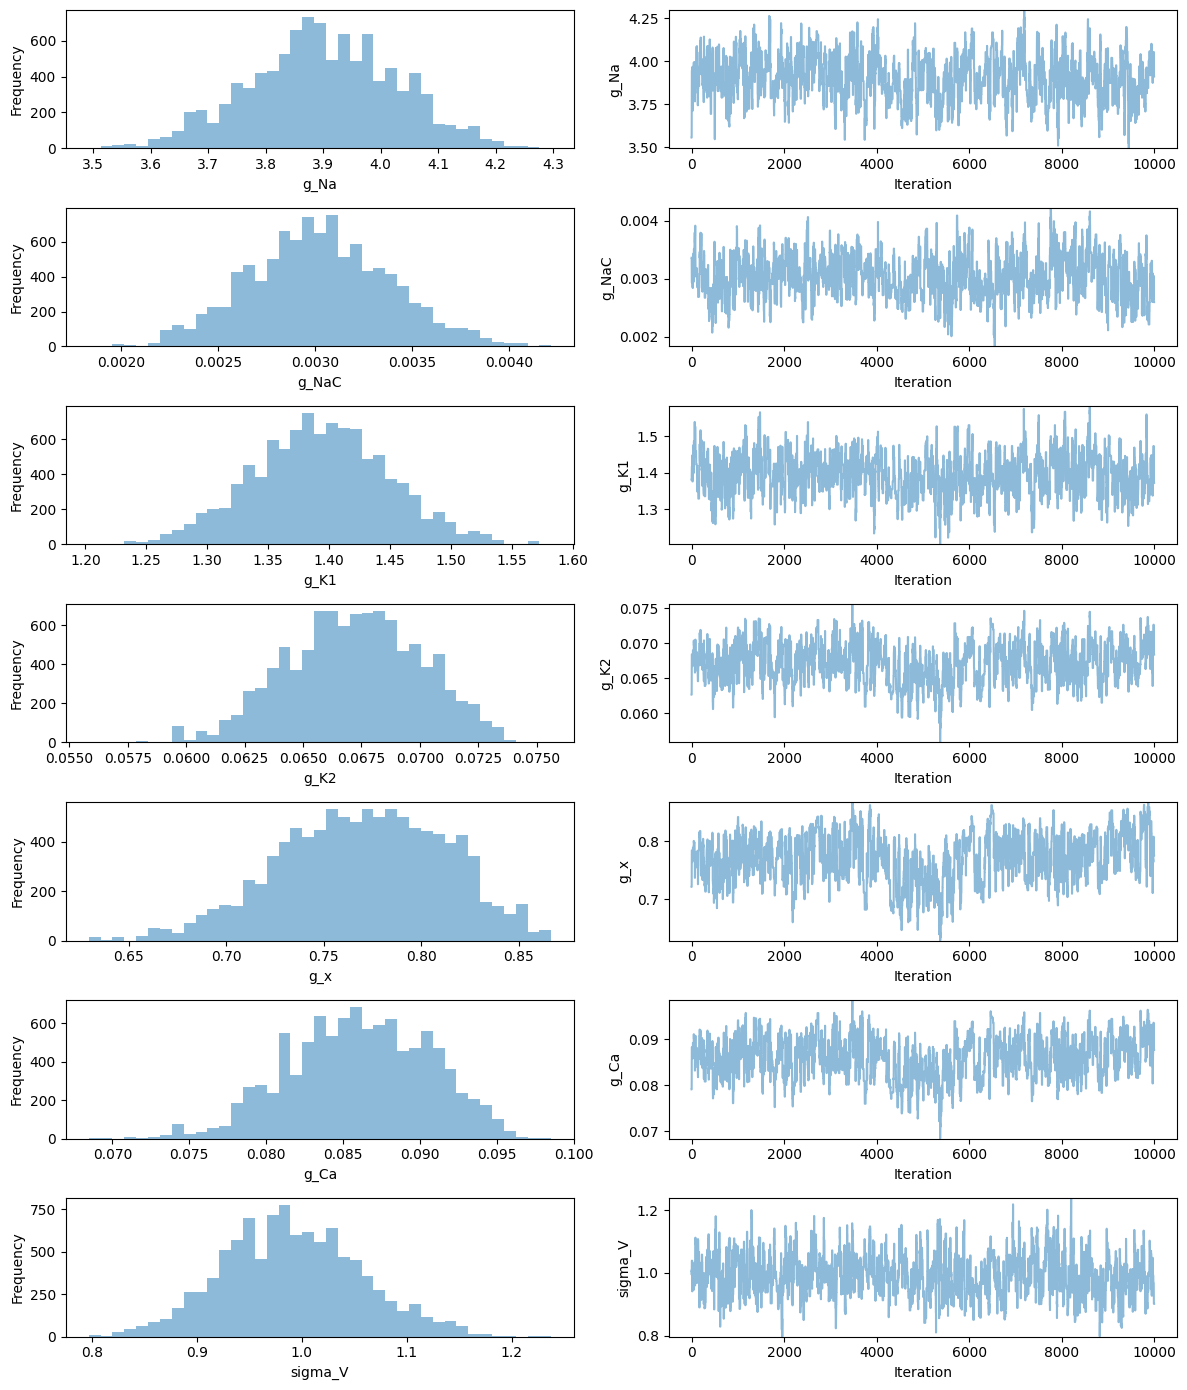

In [28]:
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Predicted time series plots

#### Chain 1

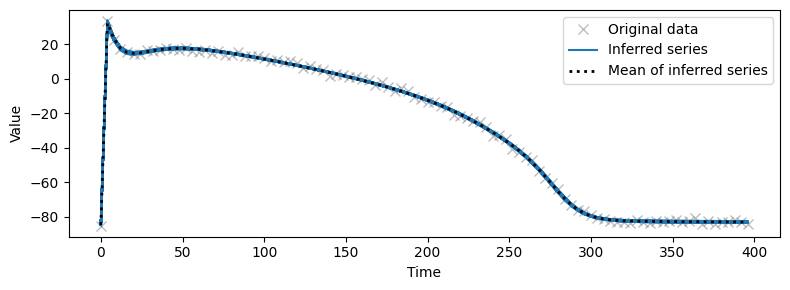

In [29]:
pints.plot.series(chains[0, :], problem)
plt.savefig("inference_outputs/series_conductances_tol.png")

### Pairwise plots

Here we will see which parameters are most correlated.

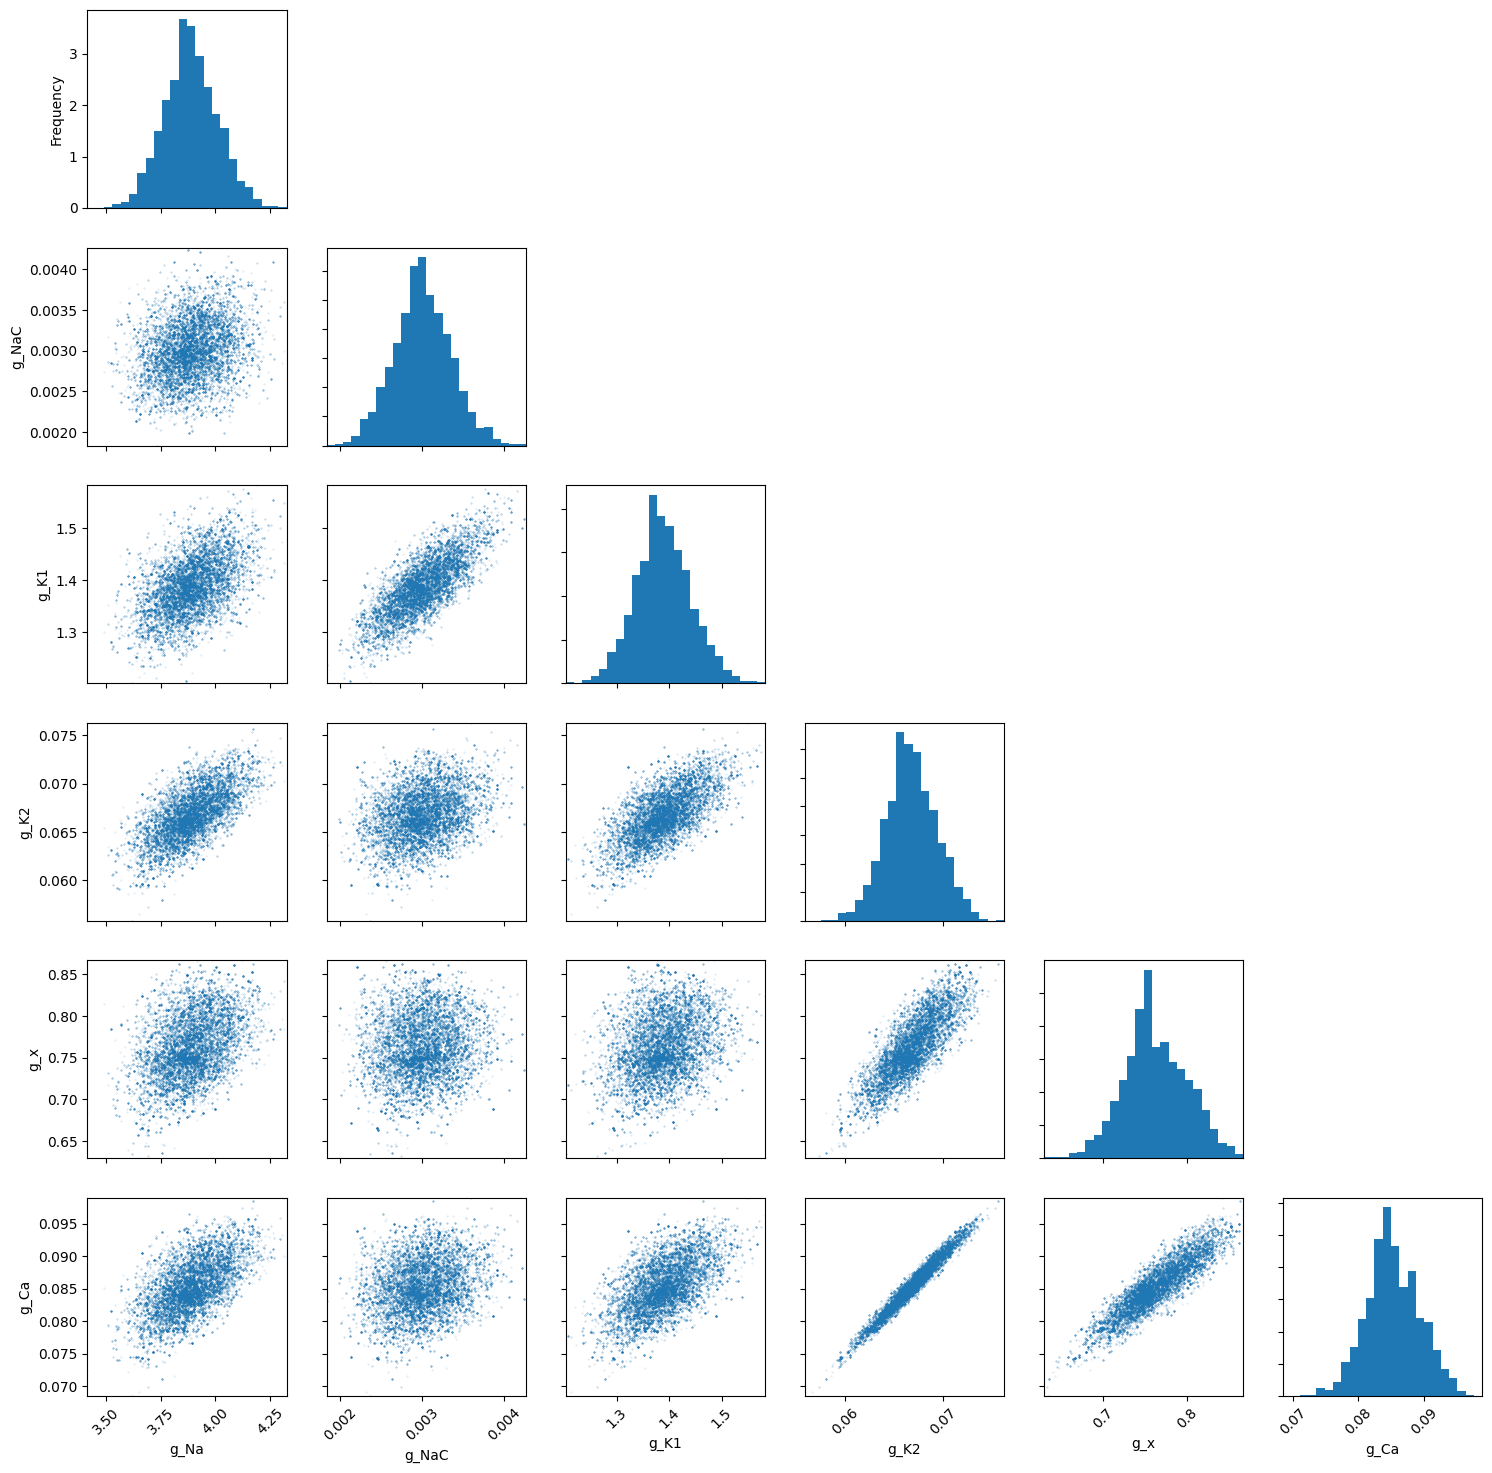

In [25]:
pints.plot.pairwise(chains[0, :, :-1], parameter_names=all_param_names[:-1])
plt.savefig("inference_outputs/pairwise_conductances_tol.png")

## Extracting posterior distributions

Finally, we will use the stationary chain data to extract posteriors. Assuming chains have converged, we can use their 
iterations as samples from the posterior.

In [30]:
chains_df = pd.DataFrame(columns=all_param_names + ['chain'])
for i in range(num_chains):
    chain_i_df = pd.DataFrame(chains[i], columns=all_param_names)
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_11892\1106702706.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean g_Na: 3.9004643590853774, std dev g_Na: 0.1284550579389272
Mean g_NaC: 0.0030218043150433823, std dev g_NaC: 0.00036291092860440174
Mean g_K1: 1.3936577221725674, std dev g_K1: 0.05626215913788749
Mean g_K2: 0.06718018658282623, std dev g_K2: 0.002877627767405428
Mean g_x: 0.7699532649529619, std dev g_x: 0.04220763097546584
Mean g_Ca: 0.08603544094831114, std dev g_Ca: 0.00453948748957763


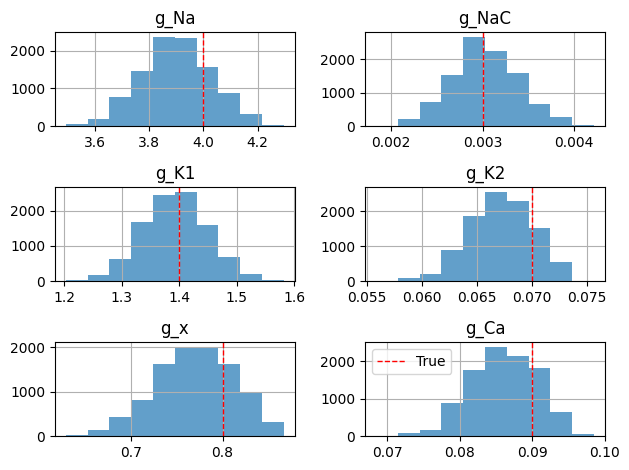

In [31]:
means = []
std_devs = []
for name in param_names:
    mean = np.mean(chains_df[name])
    std_dev = np.std(chains_df[name])
    print(f"Mean {name}: {mean}," 
          f" std dev {name}: {std_dev}")
    means.append(mean)
    std_devs.append(std_dev)
output_param_df["Posterior mean"] = means
output_param_df["Posterior std dev"] = std_devs
histograms = chains_df.hist(column=param_names, alpha=0.7)
for i in range(3):
    for j in range(2):
        ax = histograms[i][j]
        ax.axvline(parameters[i * 2 + j], color='r', linestyle='dashed', linewidth=1, label="True")
plt.tight_layout()
plt.legend()
plt.savefig("inference_outputs/posteriors_conductances_tol.png")

Finally, write all of the parameter data to a final .csv file

In [32]:
output_param_df.insert(0, "Name", all_param_names[:-1])
output_param_df.to_csv("param_info_tol.csv")

## Plotting the likelihood surface

Following [$^{[4]}$](#Sources), we wish to plot the likelihood surface to see if there are any discontinuities. This may imply that the differential
equation solver is of the incorrect tolerance.

In [105]:
parameters = [4, 0.003, 1.4, 0.07, 0.8, 0.09, 1.0]
likelihoods = []
g_Na_list = []
for i in range(100):
    g_Na = i / 10
    g_Na_list.append(g_Na)
    parameters[0] = g_Na
    llhd = log_likelihood(np.array(parameters))
    likelihoods.append(llhd)
    print(f"g_Na: {g_Na}, likelihood: {llhd}")

g_Na: 0.0, likelihood: -230825.4279941542
g_Na: 0.1, likelihood: -227793.23206179112
g_Na: 0.2, likelihood: -223437.178657597
g_Na: 0.3, likelihood: -218124.70634077454
g_Na: 0.4, likelihood: -211696.59772762164
g_Na: 0.5, likelihood: -203172.07313776435
g_Na: 0.6, likelihood: -189758.9461445217
g_Na: 0.7, likelihood: -158273.9285418699
g_Na: 0.8, likelihood: -16060.204791626156
g_Na: 0.9, likelihood: -8942.724559160706
g_Na: 1.0, likelihood: -6122.1619735675995
g_Na: 1.1, likelihood: -4528.628931141807
g_Na: 1.2, likelihood: -3504.4196621556916
g_Na: 1.3, likelihood: -2791.3518198604243
g_Na: 1.4, likelihood: -2269.43588362649
g_Na: 1.5, likelihood: -1873.1987251956193
g_Na: 1.6, likelihood: -1563.991967985548
g_Na: 1.7, likelihood: -1317.735760918626
g_Na: 1.8, likelihood: -1118.4567777146904
g_Na: 1.9, likelihood: -955.1251905361553
g_Na: 2.0, likelihood: -819.8192469201631
g_Na: 2.1, likelihood: -707.1754753289288
g_Na: 2.2, likelihood: -612.6002020309847
g_Na: 2.3, likelihood: -53

Text(0.5, 1.0, 'Likelihood surface varying the g_Na parameter')

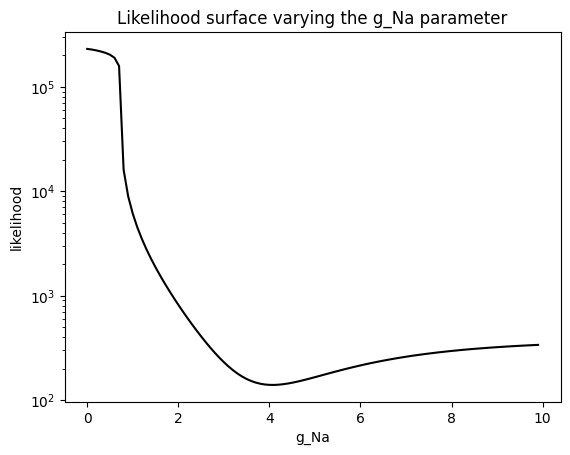

In [106]:
plt.yscale("log")
plt.plot(np.array(g_Na_list), -np.array(likelihoods), "-k")
plt.xlabel("g_Na")
plt.ylabel("likelihood")
plt.title("Likelihood surface varying the g_Na parameter")

In [107]:
def plot_likelihood(param_index, param_name, upper_bound):
    parameters = [4, 0.003, 1.4, 0.07, 0.8, 0.09, 1.0]
    likelihoods = []
    param_list = []
    for i in range(100):
        param = i / 100 * upper_bound
        param_list.append(param)
        parameters[param_index] = param
        llhd = log_likelihood(np.array(parameters))
        likelihoods.append(llhd)
    plt.yscale("log")
    plt.plot(np.array(param_list), -np.array(likelihoods), "-k")
    plt.xlabel(param_name)
    plt.ylabel("likelihood")
    plt.title(f"Likelihood surface varying the {param_name} parameter")

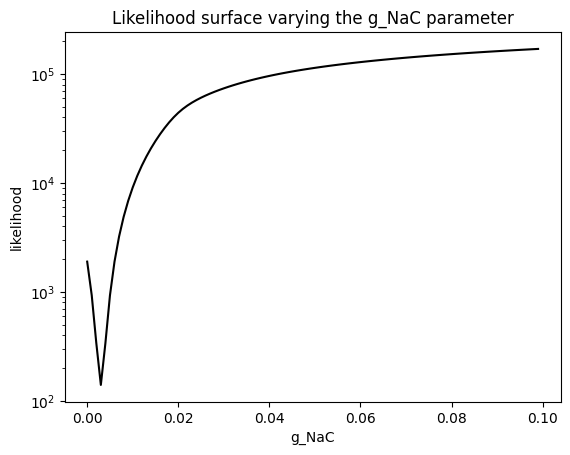

In [108]:
plot_likelihood(1, "g_NaC", 0.1)

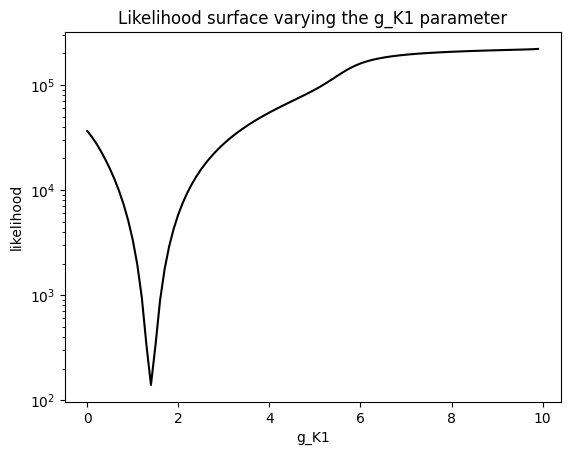

In [109]:
plot_likelihood(2, "g_K1", 10)

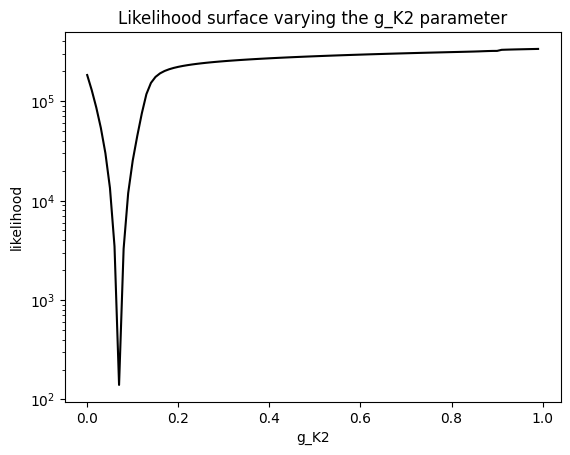

In [110]:
plot_likelihood(3, "g_K2", 1)

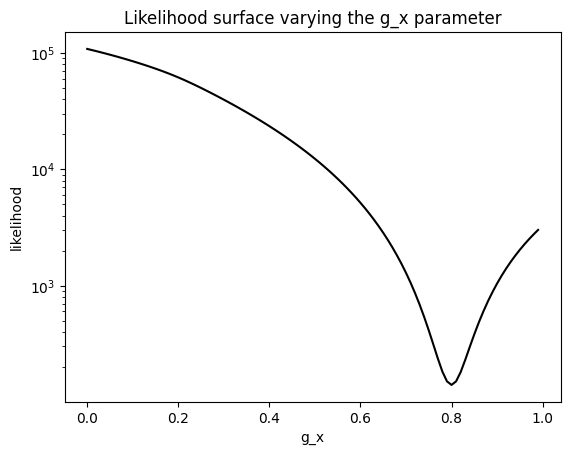

In [111]:
plot_likelihood(4, "g_x", 1)

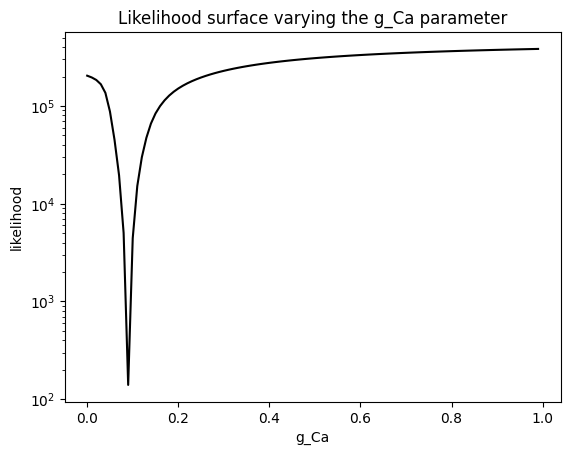

In [112]:
plot_likelihood(5, "g_Ca", 1)

## Sources
$^{[1]}$ J. Keener and J. Sneyd (1998) - Mathematical Physiology https://link.springer.com/book/10.1007/b98841

$^{[2]}$ G. W. Beeler and H. Reuter, RECONSTRUCTION OF THE ACTION POTENTIAL OF
VENTRICULAR MYOCARDIAL FIBRES, J. Physiol. **268** (1977), pp. 177-210 https://doi.org/10.1113/jphysiol.1977.sp011853

$^{[3]}$ P. Noble, F. Fenton, cellML - Beeler, Reuter 1997, date accessed: 22/03/24, https://models.cellml.org/e/1

$^{[4]}$ R. Creswell, K. M. Shepherd, B. Lambert, G. R. Mirams, C. L. Lei, S. Tavener, M. Robinson and D. J. Gavaghan, .
c.7075553.
Understanding the impa t of numerical
solvers on inference  or differential, J. R. Soc. Interface **21** (2024) pp. 20230369 https://doi.org/10.1098/rsif.2023.0369
equation models